In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/MLeng/07IBM Deep Learning

/content/drive/MyDrive/Colab Notebooks/MLeng/07IBM Deep Learning


In [ ]:
#!pip install tensorflow_cpu==2.18.0

In [ ]:
#Implementation of deep learning and NLP in research log book for text generation
'''
Context and Problem Statement:
- Research log book is a day to day record of raw data, methods, measurements, and experimental results obtained during research activities.
- The research log book occupies more than 100 pages within a few months.
- To analyze or summerise a specific task in the research log book is time-consuming.
- Therefore, this text generation was performed to support researchers to easily review their work, identify insight, and receive conclusions from the research log book.
- The script will take words/phrases as an input and predict the next words/sentences relating to the input words based on textual data noted in the research log book.
- Transformer and GPT-2 (Generative Pre-trained Transformers) models have been used to train textual dataset and generate new text.
- The textual data was converted to numerical format (tokens) by using NLP techniques such as Tokenization and Padding.
- The sparse categorical cross-entropy was defined to compute the cross-entropy loss between the labels and predictions because the labels are represented by the index of the category. It is more efficient when there are a lot of categories, like text data.
- Regularization techniques consisting of dropout layer, batch normalization layer, and early stopping were used to address overfitting in the neural network.
- Custom callbacks of monitoring validation loss, early stopping, and learning rate scheduling were determined for improving model performance.

Process: 1. Import data
         2. Text Preprocessing >>> Tokenization, Vectorization, Padding and Creating sequences of text data
         3. Custom callbacks >>> Monitoring validation loss, Early stopping, and Learning rate scheduling
         4. Transformer model
            4.1 Embedding layer
            4.2 Positional encoding
            4.3 Multiple encoder blocks >>> Multi-head attention layer, Feed-forward neural network layer, Residual Connection, and Layer Normalization
            4.4 Multiple decoder block >>> Masked multi-head attention layer, Multi-head attention layer, Feed-forward neural network layer, Residual Connection, and Layer Normalization
         5. Text generation from trained transformer model
         6. Fine-tuned GPT-2 model with unfreezing layers
         7. Text generation from trained GPT-2 model
         8. Model evaluation and Visualization of training performance with accuracy and loss curves

'''

In [ ]:
import tensorflow as tf
import keras_nlp
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import get_file
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, LayerNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
import time
import os

In [ ]:
#1. Import dataset
filename = 'Project1_Parameter_Survey_for_Metrology_Light_Source.txt'
text = open(filename, 'rb').read().decode(encoding='utf-8')
print(text[:20000])              # Preview the dataset

Parameter Survey for Metrology Light Source II
Andreas Jankowiak, Natthawut Chaisueb, Arnold Kruschinski, Carsten Mai, Teresia Olsson, Ronja Grünke, and Markus Ries
Helmholtz-Zentrum Berlin
March 29, 2025
Executive Summary

The topic of this parameter survey is a green field design for Metrology Light Source II (MLS II), a
successor source for MLS I. It is designed by Helmholtz-Zentrum Berlin (HZB) for the PhysikalischTechnische Bundesanstalt (PTB). 
The design target is a compact, green field electron storage ring based EUV radiation source with fully self-sustained infrastructure. 
High reliability, high availability, high uptime, and in particular short downtime are important design targets. Therefore, only normal
conducting technology is chosen for RF system and electromagnets. To achieve highest beam stability,
top-up operation is a design goal. The special request from the PTB for a tunable electron energy
in the range from 800 MeV down to 150 MeV excludes the use of permanent 

In [ ]:
#2. Text Preprocessing >>> Tokenization, Vectorization, Padding and Creating sequences of text data
# Tokenization >>> splits text into smaller units such as words/phrases called “tokens” by using whitespace or punctuation.
# Vectorization >>> converts text into numerical data by using one-hot encoding, which is assigning a unique integer value to each word.
# Padding >>> ensures that all sequences have the same length.
vocab_size = 20000            # number of words in text = 10000
seq_length = 256              # sequence length (like time step in time series)
vectorizer = TextVectorization(max_tokens=vocab_size, output_mode='int')        # define TextVectorization layer >>> tokenize, vectorize and pad the text sequences
text_ds = tf.data.Dataset.from_tensor_slices([text]).batch(1)                   # Creates a Dataset whose elements are slices of the given tensors >>> preserves the structure of the input tensors, removing the first dimension of each tensor and using it as the dataset dimension
vectorizer.adapt(text_ds)                                                       # adapt the vectorizer to the text data
vectorized_text = vectorizer([text])[0]                                         # vectorize the text data >>> transform the text into numerical format
print("Vectorized text shape:", vectorized_text.shape)
print("First 10 vectorized tokens:", vectorized_text.numpy()[:10])

# Create sequences of text data >>> to get X and Y training dataset
def create_sequences(text, seq_length):                         # Split the text data into sequences of the specified length.
    input_seqs = []
    target_seqs = []
    for i in range(len(text) - seq_length):
        input_seq = text[i:i + seq_length]                      # X[i] = each sequences will contain a specific number of the text data
        target_seq = text[i + 1:i + seq_length + 1]             # Y[i] = corresponding label will be the next text in the text data
        input_seqs.append(input_seq)
        target_seqs.append(target_seq)
    return np.array(input_seqs), np.array(target_seqs)
X, Y = create_sequences(vectorized_text.numpy(), seq_length)    # Generate sequences
# Check if sequences are correctly generated
print("Number of sequences generated:", len(X))
print("Sample input sequence:", X[0] if len(X) > 0 else "No sequences generated")
# Check if X and Y are not empty
assert X.size > 0, "Input data X is empty"
assert Y.size > 0, "Target data Y is empty"
X = tf.convert_to_tensor(X)                                     # Convert the sequences into TensorFlow tensors for training
Y = tf.convert_to_tensor(Y)
print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)


Vectorized text shape: (6045,)
First 10 vectorized tokens: [ 134   88    4   68  123   73   24 1215  927  868]
Number of sequences generated: 5789
Sample input sequence: [ 134   88    4   68  123   73   24 1215  927  868 1165 1206  922 1167
  901  676  853  755  982    5  894  757  507  399  895 1263 1287 1039
  690    2  664    3   16  134   88    9    7  371   99   26    4   68
  123   73   24   13   24    7  209   73    4   13   22   69    9  239
   31  507  399  232    4    2  829  563   66    2   26  256    9    7
  241  371   99   77   25   20  197   93   21   73   10 1003  744  187
  111  459  111  400  111  318    5    6  176  265 1077   11  156   26
  681   79  121  226  552  432    9  394    4  105   45    5  529    8
  165  367   37  442  207   30    9    7   26  509    2  260  458   50
    2   66    4    7  426   77   35    6    2   74   50  307   83  533
    8  414   83 1042    2  116    3  345   15    6    2   20  284   32
   15   11    7  374   26  151    4 1212   12    

In [ ]:
#3. Custom callbacks >>> Monitoring validation loss, Early stopping, and Learning rate scheduling
class LossHistory_(tf.keras.callbacks.Callback):     # monitoring the validation loss
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(epoch))
        print(' - lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):                                # Define a learning rate scheduler >>> that reduces the learning rate exponentially
    initial_lrate = 1e-4
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

loss_history_ = LossHistory_()                       # monitoring the validation loss
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, mode = 'min', min_delta=0.01)             # Stops training when loss no longer improves, preventing overfitting. >>> monitor='val_loss' considers validation loss instead of loss
lr_scheduler = LearningRateScheduler(exp_decay)                                                                                 # Define a learning rate scheduler
#lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)                           # Reduces learning rate when validation loss plateaus, allowing better optimization.

callbacks_list_ = [loss_history_, lr_scheduler, early_stopping]

In [ ]:
#4. Transformer model
# define the Transformer layers >>> combines multi-head self-attention with a feed-forward neural network, normalization layers, dropout layers
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)            # by splitting the input into multiple heads which allows the model to focus on different parts of the sequence simultaneously.
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# define Trandformer model >>> including embedding, positional encoding, and multiple Transformer blocks
class TransformerModel(Model):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length):
        super(TransformerModel, self).__init__()
        self.embedding = Embedding(vocab_size, embed_dim)                                                            # Embedding layer
        self.pos_encoding = self.positional_encoding(seq_length, embed_dim)                                          # Positional encoding layer
        self.transformer_blocks = [TransformerBlock(embed_dim, num_heads, ff_dim) for _ in range(num_layers)]        # Multiple transformer blocks
        self.dense = Dense(vocab_size)

    def positional_encoding(self, seq_length, embed_dim):
        angle_rads = self.get_angles(np.arange(seq_length)[:, np.newaxis], np.arange(embed_dim)[np.newaxis, :], embed_dim)
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        pos_encoding = angle_rads[np.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def get_angles(self, pos, i, embed_dim):
        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(embed_dim))
        return pos * angle_rates

    def call(self, inputs, training=False):
        seq_len = tf.shape(inputs)[1]
        x = self.embedding(inputs)
        x += self.pos_encoding[:, :seq_len, :]
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)  # Pass training argument correctly
        output = self.dense(x)
        return output


In [ ]:
#4. Transformer model
embed_dim = 64          # Embedding size, Dense(embed_dim), embed_dim = dimensionality of the output space
num_heads = 4            # Number of attention heads >>> splits the input into multiple heads for parallel attention computation
ff_dim = 128             # Hidden layer size in feed forward network inside transformer
num_layers = 4           # number of the Transformer layers (TransformerBlock)
model = TransformerModel(vocab_size, embed_dim, num_heads, ff_dim, num_layers, seq_length)             # Build the Transformer model

# create model
_ = model(tf.random.uniform((1, seq_length), maxval=vocab_size, dtype=tf.int32))        # Provide input shape to build the model by passing a dummy input with maxval specified
perplexity = keras_nlp.metrics.Perplexity(from_logits=True)                             # For language models, measures how well a model predicts a text sequence. >>> Lower perplexity indicates better performance.
model.compile(
    optimizer=keras.optimizers.Adam(),           # "AdamW" for weight decay in Adam
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    weighted_metrics=["accuracy", perplexity],
)
print(model.summary())
history = model.fit(X, Y, epochs=20, batch_size=32, callbacks=callbacks_list_)         # Train the transformer model on the full input (X) and target (Y) sequences

# model evaluation
loss, accuracy, perplexity = model.evaluate(X, Y)
print("Loss: ", loss)
print("Accuracy: ", accuracy)
print("Perplexity: ", perplexity)

Model: "transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (1, 256, 64)                │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ ?                           │          83,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ ?                           │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_2                  │ ?                           │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_3                  │ ?                           │          83,200 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (1, 256, 20000)             │       1,300,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,912,800 (11.11 MB)

 Trainable params: 2,912,800 (11.11 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0517 - loss: 9.3774 - perplexity: 12399.4961 - lr: 9.048374180359596e-05
181/181 ━━━━━━━━━━━━━━━━━━━━ 1556s 9s/step - accuracy: 0.0518 - loss: 9.3745 - perplexity: 12369.9512 - learning_rate: 1.0000e-04
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0705 - loss: 7.5654 - perplexity: 1960.3243 - lr: 8.187307530779819e-05
181/181 ━━━━━━━━━━━━━━━━━━━━ 1597s 9s/step - accuracy: 0.0706 - loss: 7.5639 - perplexity: 1957.5543 - learning_rate: 9.0484e-05
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0805 - loss: 6.6394 - perplexity: 767.1052 - lr: 7.408182206817179e-05
181/181 ━━━━━━━━━━━━━━━━━━━━ 1579s 9s/step - accuracy: 0.0805 - loss: 6.6387 - perplexity: 766.5867 - learning_rate: 8.1873e-05
Epoch 4/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.0804 - loss: 6.2199 - perplexity: 503.0169 - lr: 6.703200460356394e-05
181/181 ━━━━━━━━━━━━━━━━━━━━ 1576s 9s/step - accuracy: 0.0804

In [ ]:
#5. Text generation from trained transformer model
def generate_text(model, start_string, num_generate=100, temperature=1.0):
    input_eval = vectorizer([start_string]).numpy()          # Convert the start string to numerical format (a vectorized format)
    # Ensure the input length is the same as the model's expected input shape
    if input_eval.shape[1] < seq_length:
        padding = np.zeros((1, seq_length - input_eval.shape[1]))      # Pad the input if it's shorter than the expected sequence length
        input_eval = np.concatenate((padding, input_eval), axis=1)
    elif input_eval.shape[1] > seq_length:
        input_eval = input_eval[:, -seq_length:]                       # Truncate the input if it's longer than the expected sequence length
    input_eval = tf.convert_to_tensor(input_eval)             # Convert to TensorFlow tensors
    text_generated = []                                       # Initialize an empty list to store generated text
    # Start generating text
    for i in range(num_generate):
        # Make predictions using the model
        predictions = model(input_eval)
        predictions = predictions[0]                     # Remove only the batch dimension, keep the logits as 2D (batch_size, vocab_size) >>> This should be of shape [vocab_size]
        predictions = predictions / temperature          # Apply temperature to predictions
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()       # Use a categorical distribution to predict the next word
        # Update the input tensor to include the predicted word, maintaining the sequence length
        input_eval = np.append(input_eval.numpy(), [[predicted_id]], axis=1)     # Append predicted token
        input_eval = input_eval[:, -seq_length:]                                 # Keep only the last `seq_length` tokens, if -5 = Keep only the last 5 tokens to match input shape
        input_eval = tf.convert_to_tensor(input_eval)                            # Convert back to tensor
        # Append the predicted word to the generated text
        text_generated.append(vectorizer.get_vocabulary()[predicted_id])
    return start_string + ' ' + ' '.join(text_generated)       # Return the generated text starting from the initial seed

# Generate text with temperature control
start = time.time()
start_string = "Light source"
generated_text = generate_text(model, start_string, temperature=0.7)            # Lower temperature for more focused predictions, increase the temperature to increase “creativity” by allowing the network to more likely make suboptimal predictions
end = time.time()
print("\nTramsformers model output:")
print(generated_text)
print(f"\nTotal time elapsed: {end - start:.2f}s")



Tramsformers model output:
Light source the the the of to the with radiation the the of lattice of of for the of to of the and with with ptb of of for of and for of the and in and and and the for to is a to in in and of for and for the in the about the to and which in of are is and to of lattice ring is of of is and for to 12 of of of with with is and the for of and to and larger from with as and in octupole to there is the of

Total time elapsed: 18.07s


In [ ]:
#6. Fine-tuned GPT-2 model with unfreezing layers
'''
Ref:
- https://keras.io/keras_hub/api/models/gpt2/gpt2_causal_lm/
- https://keras.io/examples/generative/gpt2_text_generation_with_kerasnlp/?fbclid=IwY2xjawJUivtleHRuA2FlbQIxMAABHQbDJQ3UBCiT0y8K4WVy3u46MuxfHWsfgHp3uGLCQjyIOgd6CueqdfcEKg_aem_IAbjKlxK4FOmzWPIuZWO4g#finetune-on-reddit-dataset

'''
#!pip install --upgrade keras-nlp
#!pip install --upgrade keras>=3

os.environ["KERAS_BACKEND"] = "tensorflow"       # os.environ["KERAS_BACKEND"] = "jax"  # or "tensorflow" or "torch"
keras.mixed_precision.set_global_policy("mixed_float16")

# Load and set hyperparameters of GPT-2 model
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset("gpt2_base_en")             # Load a pre-trained GPT-2 model
#tokenizer = keras_nlp.models.GPT2Tokenizer.from_preset("gpt2_base_en", vocabulary=vocab, merges=merges)
preprocessor = keras_nlp.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
#    tokenizer=tokenizer,
    sequence_length=256,                                                        # To speed up training and generation, we use preprocessor of length 128 instead of full length 1024.
)
gpt2_lm.backbone.vocabulary_size = 20000
gpt2_lm.backbone.max_sequence_length = 256
gpt2_lm.backbone.num_layers = 4
gpt2_lm.backbone.num_heads = 4
gpt2_lm.backbone.hidden_dim = 64
gpt2_lm.backbone.intermediate_dim = 128
gpt2_lm = keras_nlp.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=None,
)

# Preprocess your text data
'''
1. use only X=text data for training and define "preprocessor=preprocessor" in keras_nlp.models.GPT2CausalLM.from_preset
X = text.split('.')        # Only X can be used as a training data for gpt2_lm.fit(x=X, epochs=num_epochs, batch_size=32)

2. use sequences of text data as X and Y for training
padding_mask = np.ones_like(X.numpy())                   # padding mask = a binary mask (0s=padding tokens that should be ignored and 1s=real tokens,no padding) that identifies which positions in the input sequence are padding token
X_gpt2 = {                                                    # Create the input dictionary
    "token_ids": X.numpy(),
    "padding_mask": padding_mask
}
Y_gpt2 = Y.numpy()

3. use only 2 sequences(min sequence) of text data as X and Y for training and define "preprocessor=None" in keras_nlp.models.GPT2CausalLM.from_preset
'''
tokenized_text = preprocessor(text)                                             # Tokenize the text using the preprocessor, output is token_ids, padding_mask, ...
token_ids = tokenized_text[0]['token_ids'].numpy()
padding_mask = np.multiply(tokenized_text[0]['padding_mask'].numpy(), 1)        # padding mask = a binary mask (0s=padding tokens that should be ignored and 1s=real tokens,no padding) that identifies which positions in the input sequence are padding token
X_gpt2 = {                                                                           # Create the input dictionary
    "token_ids": np.array([token_ids.tolist()]*2),                              # 2 sequences are minimum sequence for training
    "padding_mask": np.array([padding_mask.tolist()]*2)
}
Y_gpt2 = np.array([np.roll(token_ids, -1, axis=0).tolist()]*2)                       # Create target data by shifting token_ids by one position

# Freezing lower layers >>> to retain the model’s foundational understanding (language patterns and grammar) while allowing the upper layers to adapt to new.
'''
for father_layer in gpt2_lm._flatten_layers():
  father_layer.trainable = False
  if father_layer.name in ["gpt2_causal_lm", "gpt2_backbone"]:
    father_layer.trainable = True
  if father_layer.name == ("transformer_layer_" + str(lower_layer_n)):
    father_layer.trainable = True
    break
'''

# GPT2 model
perplexity = keras_nlp.metrics.Perplexity(from_logits=True)                     # For language models, measures how well a model predicts a text sequence. >>> Lower perplexity indicates better performance.
gpt2_lm.compile(
    optimizer=keras.optimizers.Adam(),           # "AdamW" for weight decay in Adam
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    weighted_metrics=["accuracy", perplexity],
    sampler="top_k",                             # Sampling Method like Optimizer and Activations
)
print(gpt2_lm.summary())
history_gpt2 = gpt2_lm.fit(x=X_gpt2, y=Y_gpt2, epochs=20, batch_size=32, callbacks=callbacks_list_)         # preprocessor will be automatically called inside fit method since GPT2CausalLM is a keras_nlp.models.Task instance.

# model evaluation
loss_gpt2, accuracy_gpt2, perplexity_gpt2 = gpt2_lm.evaluate(X_gpt2, Y_gpt2)
print("Accuracy: ", accuracy_gpt2)
print("Loss: ", loss_gpt2)
print("Perplexity: ", perplexity_gpt2)


NameError: name 'os' is not defined

In [ ]:
#7. Text generation from trained GPT-2 model
start = time.time()
text_input = "Light source"

# Preprocess input text
tokenized_text = preprocessor(text_input)                                       # Tokenize the text using the preprocessor, output is token_ids, padding_mask, ...
token_ids = tokenized_text[0]['token_ids'].numpy()
padding_mask = np.multiply(tokenized_text[0]['padding_mask'].numpy(), 1)        # padding mask = a binary mask (0s=padding tokens that should be ignored and 1s=real tokens,no padding) that identifies which positions in the input sequence are padding token
X_text_input = {                                                                # Create the input dictionary
    "token_ids": np.array([token_ids.tolist()]),
    "padding_mask": np.array([padding_mask.tolist()])
}

# Text generation
output = gpt2_lm.generate(X_text_input, max_length=100, stop_token_ids=None)

# Decode the token_ids to text
decoded_text = preprocessor.tokenizer.detokenize(output['token_ids'])
decoded_string = " ".join([str(token) for token in decoded_text])      # create single string
end = time.time()

print("\nFine-tuned GPT-2 model output:")
print(decoded_string)  # Print the decoded string
print(f"\nTotal time elapsed: {end - start:.2f}s")



Fine-tuned GPT-2 model output:
<|endoftext|>Light source<|endoftext|>The latest update for Windows Phone 8.1 includes support for the Windows Phone 8.1 Mobile SDK for Android, a new SDK for Windows Phone and the Android Debug Bridge (API). The latest Android SDK is a fully functional Android operating system with support for 64-bit Windows Phone 8.1 devices. It is a fully-featured Android operating system with support for 64-bit devices with support for 32-bit Windows Phone 8.1 devices.

Windows Phone 8.1 is a fully-featured Android operating system with support for 64-bit Windows Phone 8.1 devices.

The Android Debug Bridge (API) is a fully-featured Android operating system with support for 64-bit Windows Phone 8.1 devices. It enables you to connect to the web, send and receive SMS, manage your device settings and more.

The Android Debug Bridge (API) provides you with the highest level of security and reliability. It supports a range from hardware and software updates to security fi

              Model      Loss  Accuracy                    Perplexity
0      Transformers  4.565350  0.209989  <Perplexity name=perplexity>
1  Fine-tuned GPT-2  0.676899  0.871094                      1.967766


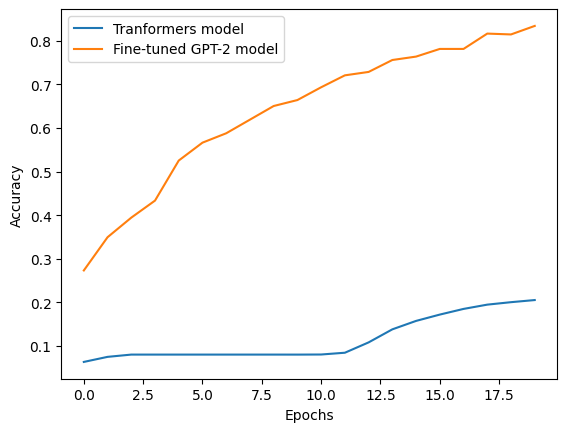

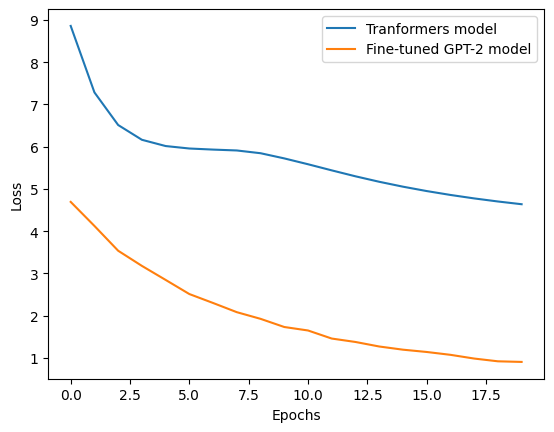

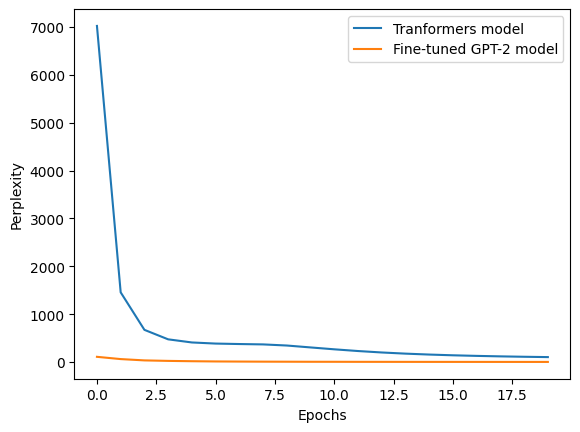

In [ ]:
#8. Model evaluation and visualization of training performance with accuracy and loss curves
# Model evaluation
data = {
    'Model': ['Transformer', 'Fine-tuned GPT-2'],
    'Loss': [loss, loss_gpt2],
    'Accuracy': [accuracy, accuracy_gpt2],
    'Perplexity': [perplexity, perplexity_gpt2]
}
df = pd.DataFrame(data)
print(df)

# Visualization of training performance with accuracy and loss curves
# Plot accuracy
plt.plot(history.history['accuracy'], label='Tranformer model')
plt.plot(history_gpt2.history['accuracy'], label='Fine-tuned GPT-2 model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(False)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Tranformer model')
plt.plot(history_gpt2.history['loss'], label='Fine-tuned GPT-2 model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

# Plot perplexity
plt.plot(history.history['perplexity'], label='Tranformer model')
plt.plot(history_gpt2.history['perplexity'], label='Fine-tuned GPT-2 model')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
# Fine-tuning GPT-2 model using KerasNLP: with freezing layer
'''
- Freeze the lower layers when fine-tuning GPT-2 is a strategic move to retain the model’s foundational understanding while allowing the upper layers to adapt to new.
- Benefit: - Preserve Core Knowledge: The lower layers capture general language patterns and grammar. >>> Freezing them ensures this foundational knowledge isn’t overwritten.
           - Efficient Training: It reduces the computational load, making the fine-tuning process faster and less resource-intensive.
           - Prevent Overfitting: By only updating the upper layers, you minimize the risk of the model overfitting to your specific dataset.

Ref: https://medium.com/@shansteinway/fine-tune-your-own-gpt-2-model-with-keras-2-for-generate-text-e3f1514598ee
'''

'''
import keras_nlp
import keras
import tensorflow as tf
import nltk
import progressbar
import pydot
import graphviz

################################################################################
# Load model and freeze layers
def _freeze_layers(model, lower_layer_n):
    """
    :param model:
    :return: model
    """
    print("backbone num_layers:", model.backbone.num_layers)

    for father_layer in model._flatten_layers():

        father_layer.trainable = False
        if father_layer.name in ["gpt2_causal_lm", "gpt2_backbone"]:
            father_layer.trainable = True
        if father_layer.name == ("transformer_layer_" + str(lower_layer_n)):  # 7,089,408/124,439,808 = 5.7%
            father_layer.trainable = True
            break
    return model

def _model_profile(model, preprocessor):

    # tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True, show_dtype=True, expand_nested=True,
    #                           show_trainable=True, show_layer_activations=True)
    preprocessor.build(model.input_shape)
    print("model layers:\n", model.layers)
    print("model summary:\n")
    model.summary()

def load_model(model_name='gpt2_base_en'):
    """
    :param model_name:
    :return: gpt2_preprocessor, model
    """
    model, gpt2_preprocessor, model_bb, gpt2_tokenizer = load_pre_model(model_name)

    model_bb = _modify_backbone(model_bb, gpt2_preprocessor)
    print("\n-pretrained model info:\n")
    _model_profile(model, gpt2_preprocessor)

    print("\n-pretrained model output:\n")
    sampler = samplers(pm.dic_pm['sampler'])
    model.compile(sampler=sampler)
    output = model.generate(prompt(), max_length=output_max_length)
    output_str = str(output.numpy().decode("utf-8")).strip('\n')

    print("\n-save pretrained model...\n")
    model.save(pre_model_path, overwrite=True)

    if pm.dic_pm['freeze_layer']:

        model = _freeze_layers(model, pm.dic_pm['freeze_num'])
        print("model with freeze_layer:\n")
        _model_profile(model, gpt2_preprocessor)

    return gpt2_preprocessor, model

################################################################################
# Create Dataset
# If sentence length < max_length, merge the sentence to a longer one.
def _merge_sentences(sentences, max_length):
    """
    :param sentences: sentences= one tokenized article
    :param max_length:
    :return:
    """
    # sentence length< max_length, merge sentence.
    res = []
    cur_len = 0
    cur_sentences = []
    for s in sentences:
        if cur_len + len(s) > max_length:
            # If adding the next sentence exceeds `max_length`, we add the
            # current sentences into collection
            res.append(" ".join(cur_sentences))
            cur_len = len(s)
            cur_sentences = [s]
        else:
            cur_len += len(s)
            cur_sentences.append(s)
    res.append(" ".join(cur_sentences))
    return res

# Tokenize and preprocess: If an individual sequence in your dataset is longer than the sequence_length specified for the fine-tuning task, the preprocessor will truncate it to fit within that length. >>> Usually, it will truncate from the end of the sequence, preserving the beginning tokens which are often considered more informative.
def _token_article(preprocessor, articles):

    all_sentences = []
    count = 0
    widgets = [' [', progressbar.Timer(format='elapsed time: %(elapsed)s'),
               '] ', progressbar.Bar('*'), ' (', progressbar.ETA(), ') ', ]
    # Render a progressbar to track progress
    bar = progressbar.ProgressBar(max_value=num_articles_to_process // progressbar_update_freq + 2,
                                  widgets=widgets).start()

    for article in articles:
        article = pm.dic_pm['ctl_token'] + article
        # split article into sentences
        sentences = tokenize.sent_tokenize(article, pm.dic_pm['language'])
        combined_res = _merge_sentences(sentences, characters_max_length)
        all_sentences.extend(combined_res)
        count += 1
        if count % progressbar_update_freq == 0:
            bar.update(count / progressbar_update_freq)
        if count >= num_articles_to_process:
            break
    all_sentences_length = len(all_sentences)
    train_sentences = all_sentences[:int(all_sentences_length*train_sentences_rate)]
    tf_train_ds = tf.data.Dataset.from_tensor_slices(train_sentences)
    processed_ds = tf_train_ds.map(preprocessor, tf.data.AUTOTUNE).batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)

    print("iteration num: ", processed_ds.cardinality().numpy())
    return processed_ds

# Create dataset for training and validation
def _pre_proc_ds_list(preprocessor, **kwargs):  # tokenize and merger a longer context
    # Read JSON data
    print("\n-load Json data set...\n")
    ds_list = pm.dic_pm['ds_list']
    ds_co = []
    for name in ds_list:
        print("data set name: ", name)
        with open(path_ds + name, 'r') as json_file:
            json_data = json.load(json_file)
        if 'title' in list(json_data[0].keys()):
            json_data = _add_special_token(json_data)
        ds_co = ds_co + json_data

    random.shuffle(ds_co)
    json_data_text = [item["text"] for item in ds_co]
    processed_ds = _token_article(preprocessor, json_data_text)

    num = processed_ds.cardinality().numpy()
    processed_ds_train = processed_ds.take(int(0.9 * num))
    processed_ds_val = processed_ds.take(int(0.1 * num))

    return processed_ds_train, processed_ds_val

################################################################################
# Fine-tuning
def _callback():
    callback_list = list()
    # loss,accuracy,val_loss
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(finetune_model_path, monitor='accuracy', save_best_only=True)

    callback_list.append(early_stopping)
    callback_list.append(checkpoint)

    return callback_list

def train(model, ds, ds_val):
    start = time.time()

    tf.keras.mixed_precision.set_global_policy("mixed_float16")

    print("\n-set fine-tune parameter...\n")
    # By setting it to False, indicating that you will handle all preprocessing steps externally.
    # This might be useful if you have custom preprocessing requirements
    model.include_preprocessing = False


    print("\n-start compile model...\n")
    sampler = pre_model.samplers("top_k")
    perplexity = keras_nlp.metrics.Perplexity(from_logits=True)
    model.compile(
        sampler=sampler,
        optimizer=_optimizer("AdamW"),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        weighted_metrics=["accuracy", perplexity])

    print("\n-start fine tune model...\n")
    model.fit(ds, epochs=num_epochs, validation_data=ds_val, callbacks=_callback())

    loss_t, accuracy_t, perplexity_t = model.evaluate(ds)
    loss_v, accuracy_v, perplexity_v = model.evaluate(ds_val)

    end = time.time()
    total = int((end-start)/60)
    iteration = ds.cardinality().numpy()

    post_model.hyperparameter_prints(loss_t=loss_t, accuracy_t=accuracy_t, perplexity_t=perplexity_t,
                                     loss_v=loss_v, accuracy_v=accuracy_v, perplexity_v=perplexity_v,
                                     total=total, iteration=iteration)

    print("\n-fine tune model output:\n")
    output = model.generate(pre_model.prompt(), max_length=output_max_length)
    output_str = str(output.numpy().decode("utf-8")).strip('\n')
    print("model output after fine-tune:\n", output_str)

    return model

# Text generation
def _generate_text(model, text):
    # text = utils.add_special_token(text, None)
    output = model.generate(text, max_length=output_max_length)
    output_str = str(output.numpy().decode("utf-8")).strip('\n')
    print("model output after fine-tune:\n", output_str)


    return output_str
'''

In [ ]:
#Storytelling
'''
1. Context and Problem Statement
    - Problem
    - Background
    - Goal
2. Data and Methodology
    - Data source
    - Preprocessing step
    - Model: strength, why choose
    - Process
3. Results and Insights
    - Visualization
    - Insights
    - Explain the significant: How do these insights contribute to solving the problem or achieving the goal?
4. Actionable Recommendations and Conclusion
    - Solutions: what actions should be taken?
    - Outlook
    - Summarize the impact
5. Related topics
'''